## Import library

In [307]:
import lightgbm as lgb

from sklearn import datasets
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import gc

In [308]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [309]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [310]:
def multi_weighted_logloss_exgal(y_true, y_preds):

    classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
    class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
            
    if len(np.unique(y_true)) > len(classes):
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [311]:
def lgb_multi_weighted_logloss_exgal(y_true, y_preds):
    
    classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
    class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
        
    if len(np.unique(y_true)) > len(classes):
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

## Data import

In [322]:
# load data
#print('print train')
train = pd.read_pickle('../input/train_meta_add_feature.pickle')
test = pd.read_pickle('../input/test_meta_add_feature.pickle')

train_flux_feature_byband = pd.read_pickle('../input/train_flux_feature_byband.pickle')
test_flux_feature_byband = pd.read_pickle('../input/test_flux_feature_byband.pickle')

train_flux_feature = pd.read_pickle('../input/train_flux_feature.pickle')
test_flux_feature = pd.read_pickle('../input/test_flux_feature.pickle')

train_flux_count = pd.read_pickle('../input/train_flux_count.pickle')
test_flux_count = pd.read_pickle('../input/test_flux_count.pickle')

train_mjd_feature = pd.read_pickle('../input/mjd_train.pickle')
test_mjd_feature = pd.read_pickle('../input/mjd_test.pickle')

train_baba_feature = pd.read_pickle('../input/train_baba_mjd.pickle')
test_baba_feature = pd.read_pickle('../input/test_baba_mjd.pickle')

train_band01_feature = pd.read_pickle('../input/band01_train.pickle')
test_band01_feature = pd.read_pickle('../input/band01_test.pickle')

train_ts_feature = pd.read_pickle('../input/train_ts_result.pickle')
test_ts_feature = pd.read_pickle('../input/test_ts_result.pickle')

train_ts_byband_feature = pd.read_pickle('../input/train_ts_result_byband.pickle')
test_ts_byband_feature = pd.read_pickle('../input/test_ts_result_byband.pickle')

train_flux_diff_feature = pd.read_pickle('../input/train_flux_diff_feature.pickle')
test_flux_diff_feature = pd.read_pickle('../input/test_flux_diff_feature.pickle')

train_point_band_feature = pd.read_pickle('../input/train_byband_feature.pickle')
test_point_band_feature = pd.read_pickle('../input/test_byband_feature.pickle')

train_ts_skew_feature = pd.read_pickle('../input/train_band_skew.pickle')
test_ts_skew_feature = pd.read_pickle('../input/test_band_skew.pickle')

train_oof = pd.read_pickle('../input/oof_result_20181126_v1.pickle') # Best:1126(0.957)
test_oof = pd.read_pickle('../input/preds_result_20181126_v1.pickle') # Best:1126(0.957)

#train_oof_52 = pd.read_pickle('../input/oof_result_20181202_class52.pickle') # Best:1126(0.957)
#test_oof_52 = pd.read_pickle('../input/preds_result_20181202_class52.pickle') # Best:1126(0.957)

train_band_flux_stat_feature = pd.read_pickle('../input/train_band_flux_stat.pickle')
test_band_flux_stat_feature = pd.read_pickle('../input/test_band_flux_stat.pickle')

train_diff_stats = pd.read_pickle('../input/train_diff_stats.pickle')
test_diff_stats = pd.read_pickle('../input/test_diff_stats.pickle')

train_length = pd.read_pickle('../input/train_length.pickle')
test_length = pd.read_pickle('../input/test_length.pickle')

In [323]:
#del train_oof['target_52'],test_oof['target_52']

In [324]:
#train_flux_err_feature['flux_err_rate_max_min'] = train_flux_err_feature['flux_err_rate_min'] - train_flux_err_feature['flux_err_rate_max']
#test_flux_err_feature['flux_err_rate_max_min'] = test_flux_err_feature['flux_err_rate_min'] - test_flux_err_feature['flux_err_rate_max']

In [325]:
del train_ts_feature['index'],train_point_band_feature['index'],test_point_band_feature['index'],train_band_flux_stat_feature['index'],test_band_flux_stat_feature['index']

In [326]:
gc.collect()

252

In [327]:
#pd.set_option('display.max_columns', 100)

In [328]:
point_band_feature_use_cols = ['object_id',
'flux_max__kurtosis',
'flux_max__skewness',
'flux_min__fft_coefficient__coeff_0__attr_"abs"',
'flux_mean__kurtosis',
'flux_mean__skewness',
'flux_max_min__fft_coefficient__coeff_1__attr_"abs"',
'flux_max__fft_coefficient__coeff_1__attr_"abs"',
'flux_max_min__skewness',
'detected_mean__fft_coefficient__coeff_1__attr_"abs"',
'detected_mean__kurtosis']

#diff_stats_use_cols = ['object_id','2__median_diff','5__median_diff','diff_flux__median_diff_det','diff_flux__minimum_diff_det']

In [329]:
## 後から抜いてるからOK
#train_diff_stats = train_diff_stats[diff_stats_use_cols]
#test_diff_stats = test_diff_stats[diff_stats_use_cols]

In [330]:
train_point_band_feature = train_point_band_feature[point_band_feature_use_cols]
test_point_band_feature = test_point_band_feature[point_band_feature_use_cols]

In [331]:
train = pd.merge(train,train_flux_count,on='object_id',how='left')
train = pd.merge(train,train_flux_feature,on='object_id',how='left')
train = pd.merge(train,train_mjd_feature,on='object_id',how='left')
train = pd.merge(train,train_baba_feature,on='object_id',how='left')
train = pd.merge(train,train_band01_feature,on='object_id',how='left')
train = pd.merge(train,train_ts_feature,on='object_id',how='left')
train = pd.merge(train,train_ts_byband_feature,on='object_id',how='left')
train = pd.merge(train,train_flux_diff_feature,on='object_id',how='left')
train = pd.merge(train,train_point_band_feature,on='object_id',how='left')
train = pd.merge(train,train_band_flux_stat_feature,on='object_id',how='left')
train = pd.merge(train,train_ts_skew_feature,on='object_id',how='left') #不要？
train = pd.merge(train,train_oof,on='object_id',how='left')
#train = pd.merge(train,train_oof_52,on='object_id',how='left')
train = pd.merge(train,train_diff_stats,on='object_id',how='left')
train = pd.merge(train,train_length,on='object_id',how='left')

In [332]:
test = pd.merge(test,test_flux_count,on='object_id',how='left')
test = pd.merge(test,test_flux_feature,on='object_id',how='left')
test = pd.merge(test,test_mjd_feature,on='object_id',how='left')
test = pd.merge(test,test_baba_feature,on='object_id',how='left')
test = pd.merge(test,test_band01_feature,on='object_id',how='left')
test = pd.merge(test,test_ts_feature,on='object_id',how='left')
test = pd.merge(test,test_ts_byband_feature,on='object_id',how='left')
test = pd.merge(test,test_flux_diff_feature,on='object_id',how='left')
test = pd.merge(test,test_point_band_feature,on='object_id',how='left')
test = pd.merge(test,test_band_flux_stat_feature,on='object_id',how='left')
test = pd.merge(test,test_ts_skew_feature,on='object_id',how='left') #不要？
test = pd.merge(test,test_oof,on='object_id',how='left')
#test = pd.merge(test,test_oof_52,on='object_id',how='left')
test = pd.merge(test,test_diff_stats,on='object_id',how='left')
test = pd.merge(test,test_length,on='object_id',how='left')

In [333]:
def count_fix(df):
    df['passband_0_ratio_detect'][df['count_det'] < 3] = np.NaN
    df['passband_1_ratio_detect'][df['count_det'] < 3] = np.NaN
    df['passband_2_ratio_detect'][df['count_det'] < 3] = np.NaN
    df['passband_3_ratio_detect'][df['count_det'] < 3] = np.NaN
    df['passband_4_ratio_detect'][df['count_det'] < 3] = np.NaN
    df['passband_5_ratio_detect'][df['count_det'] < 3] = np.NaN
    return df

train = count_fix(train)
test = count_fix(test)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ip

In [334]:
train['flux__longest_strike_above_mean'] = train['flux__longest_strike_above_mean'] / train['count']
train['flux__number_crossing_m__m_1'] = train['flux__number_crossing_m__m_1'] / train['count']
train['flux__fft_coefficient__coeff_1__attr_"abs"'] = train['flux__fft_coefficient__coeff_1__attr_"abs"'] / train['count_det']

test['flux__longest_strike_above_mean'] = test['flux__longest_strike_above_mean'] / test['count']
test['flux__number_crossing_m__m_1'] = test['flux__number_crossing_m__m_1'] / test['count']
test['flux__fft_coefficient__coeff_1__attr_"abs"'] = test['flux__fft_coefficient__coeff_1__attr_"abs"'] / test['count_det']

In [335]:
train['0__longest_strike_above_mean'] = train['0__longest_strike_above_mean'] / train['count']
train['1__longest_strike_above_mean'] = train['1__longest_strike_above_mean'] / train['count']
train['2__longest_strike_above_mean'] = train['2__longest_strike_above_mean'] / train['count']
train['3__longest_strike_above_mean'] = train['3__longest_strike_above_mean'] / train['count']
train['4__longest_strike_above_mean'] = train['4__longest_strike_above_mean'] / train['count']
train['5__longest_strike_above_mean'] = train['5__longest_strike_above_mean'] / train['count']

train['0__number_crossing_m__m_1'] = train['0__number_crossing_m__m_1'] / train['count']
train['1__number_crossing_m__m_1'] = train['1__number_crossing_m__m_1'] / train['count']
train['2__number_crossing_m__m_1'] = train['2__number_crossing_m__m_1'] / train['count']
train['3__number_crossing_m__m_1'] = train['3__number_crossing_m__m_1'] / train['count']
train['4__number_crossing_m__m_1'] = train['4__number_crossing_m__m_1'] / train['count']
train['5__number_crossing_m__m_1'] = train['5__number_crossing_m__m_1'] / train['count']


test['0__longest_strike_above_mean'] = test['0__longest_strike_above_mean'] / test['count']
test['1__longest_strike_above_mean'] = test['1__longest_strike_above_mean'] / test['count']
test['2__longest_strike_above_mean'] = test['2__longest_strike_above_mean'] / test['count']
test['3__longest_strike_above_mean'] = test['3__longest_strike_above_mean'] / test['count']
test['4__longest_strike_above_mean'] = test['4__longest_strike_above_mean'] / test['count']
test['5__longest_strike_above_mean'] = test['5__longest_strike_above_mean'] / test['count']

test['0__number_crossing_m__m_1'] = test['0__number_crossing_m__m_1'] / test['count']
test['1__number_crossing_m__m_1'] = test['1__number_crossing_m__m_1'] / test['count']
test['2__number_crossing_m__m_1'] = test['2__number_crossing_m__m_1'] / test['count']
test['3__number_crossing_m__m_1'] = test['3__number_crossing_m__m_1'] / test['count']
test['4__number_crossing_m__m_1'] = test['4__number_crossing_m__m_1'] / test['count']
test['5__number_crossing_m__m_1'] = test['5__number_crossing_m__m_1'] / test['count']

In [336]:
del train['count'],train['count_det'],test['count'],test['count_det']

In [337]:
del test_diff_stats,test_oof,test_band_flux_stat_feature,test_ts_byband_feature,test_flux_feature

In [338]:
train_specz = train[train['hostgal_specz'] > 0]
train_photoz = train
test_specz = test[test['hostgal_specz'] > 0]
test_photoz = test[test['hostgal_specz'].isnull()]

In [339]:
drop_list_photoz = ['hostgal_specz','distmod','ra','decl','gal_l','ddf','hostgal_photoz_certain','flux_mean_detected','flux_mean'
             ,'ratio_by_band_max','ratio_by_band_min','ratio_by_band_mean'
             ,'ratio_by_band_detect_mean','ratio_by_band_detect_max','ratio_by_band_detect_min'
             ,'ratio_by_band_detect_median','ratio_by_band_detect_var','mwebv'
             ,'mjd_halfflux_det','mjd_sixthflux_det','diff_baba_mjd_det','max_flux_0_1_det'
             ,'flux_dif','diff_flux__kurtosis_diff_det','diff_flux__mean_diff_det','diff_flux__skewness_diff_det'
             ,'diff_flux__standard_deviation_diff_det'
             ,'0__mean_diff','1__mean_diff','2__mean_diff','3__mean_diff','4__mean_diff','5__mean_diff'
             ,'0__skewness_diff','1__skewness_diff','2__skewness_diff','3__skewness_diff','4__skewness_diff','5__skewness_diff'
             ,'0__kurtosis_diff','1__kurtosis_diff','2__kurtosis_diff','3__kurtosis_diff','4__kurtosis_diff','5__kurtosis_diff'
             ,'0__standard_deviation_diff','1__standard_deviation_diff','2__standard_deviation_diff','3__standard_deviation_diff'
             ,'4__standard_deviation_diff','5__standard_deviation_diff'
             #,'0__kurtosis','1__kurtosis','2__kurtosis','3__kurtosis','4__kurtosis','5__kurtosis'
             ]

drop_list_specz = ['hostgal_photoz','hostgal_photoz_err','distmod','ra','decl','gal_l','ddf','hostgal_photoz_certain','flux_mean_detected','flux_mean'
             ,'ratio_by_band_max','ratio_by_band_min','ratio_by_band_mean'
             ,'ratio_by_band_detect_mean','ratio_by_band_detect_max','ratio_by_band_detect_min'
             ,'ratio_by_band_detect_median','ratio_by_band_detect_var','mwebv'
             ,'mjd_halfflux_det','mjd_sixthflux_det','diff_baba_mjd_det','max_flux_0_1_det'
             ,'flux_dif','diff_flux__kurtosis_diff_det','diff_flux__mean_diff_det','diff_flux__skewness_diff_det'
             ,'diff_flux__standard_deviation_diff_det'
             ,'0__mean_diff','1__mean_diff','2__mean_diff','3__mean_diff','4__mean_diff','5__mean_diff'
             ,'0__skewness_diff','1__skewness_diff','2__skewness_diff','3__skewness_diff','4__skewness_diff','5__skewness_diff'
             ,'0__kurtosis_diff','1__kurtosis_diff','2__kurtosis_diff','3__kurtosis_diff','4__kurtosis_diff','5__kurtosis_diff'
             ,'0__standard_deviation_diff','1__standard_deviation_diff','2__standard_deviation_diff','3__standard_deviation_diff'
             ,'4__standard_deviation_diff','5__standard_deviation_diff'
             #,'0__kurtosis','1__kurtosis','2__kurtosis','3__kurtosis','4__kurtosis','5__kurtosis'
             ]

In [340]:
train_specz = train_specz.drop(drop_list_specz, axis=1)
train_photoz = train_photoz.drop(drop_list_photoz, axis=1)
test_specz = test_specz.drop(drop_list_specz, axis=1)
test_photoz = test_photoz.drop(drop_list_photoz, axis=1)

In [341]:
def check_null(data):
    print(data.isnull().sum())

pd.set_option('display.max_rows', 500)
#print(check_null(train_specz))
#print(check_null(test_specz))

In [342]:
#pd.set_option('display.max_columns', 100)
#train.describe()
#train.head(5)

In [343]:
# add mean → good result

train_specz = train_specz.replace([np.inf, -np.inf], np.nan)
test_specz = test_specz.replace([np.inf, -np.inf], np.nan)
train_photoz = train_photoz.replace([np.inf, -np.inf], np.nan)
test_photoz = test_photoz.replace([np.inf, -np.inf], np.nan)

train_mean = train.mean(axis=0)
train_specz.fillna(train_mean, inplace=True)
train_photoz.fillna(train_mean, inplace=True)
test_specz.fillna(train_mean, inplace=True)
test_photoz.fillna(train_mean, inplace=True)

In [344]:
import sys
# check used_momery
print(train_specz.shape,"行×列")
print("train:使用メモリ",round(sys.getsizeof(train) / 1073741824,2),"GB")

print(test_specz.shape,"行×列")
print("test:使用メモリ",round(sys.getsizeof(test) / 1073741824,2),"GB")

print(train_photoz.shape,"行×列")
print("train:使用メモリ",round(sys.getsizeof(train) / 1073741824,2),"GB")

print(test_photoz.shape,"行×列")
print("test:使用メモリ",round(sys.getsizeof(test) / 1073741824,2),"GB")

(5523, 180) 行×列
train:使用メモリ 0.01 GB
(120393, 179) 行×列
test:使用メモリ 5.71 GB
(7848, 181) 行×列
train:使用メモリ 0.01 GB
(3372497, 180) 行×列
test:使用メモリ 5.71 GB


## modeling_lgbm

In [345]:
y_specz.unique()

array([88, 42, 90, 67, 95, 62, 15, 52, 64])

In [346]:
gc.collect()
y = train_photoz['target']
y_specz = train_specz['target']
del train_photoz['target'],train_specz['target']
del train_photoz['object_id'], train_specz['object_id'],test_specz['object_id'],test_photoz['object_id']

In [347]:
import logging


def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm_v2.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')

In [348]:
from sklearn.model_selection import StratifiedKFold
def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    # conclusion:defalut is great!
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03, #def:0.03
        'subsample': .8,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01, #def:0.01
        'min_child_weight': 10, # def:10
        #'min_data_in_leaf':50,
        'n_estimators': 4000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3,
        #'num_leaves': 3, # add
        #'max_bin':31 #add
        #'use_missing': False
    }
        
    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
        
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]
        
        #sm = SMOTE(k_neighbors=7, n_jobs=4, random_state=42)
        #trn_x, trn_y = sm.fit_resample(trn_x, trn_y)
        #trn_x = pd.DataFrame(trn_x, columns=full_train.columns)
        #trn_y = pd.Series(trn_y)        
        
        clf = lgb.LGBMClassifier(**lgb_params) #lgb_params
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

    return clfs, importances, oof_preds


In [349]:
from sklearn.model_selection import StratifiedKFold
def train_classifiers_specz(full_train=None, y=None):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 9,
        'metric': 'multi_logloss',
        'learning_rate': 0.01, #def:0.03
        'subsample': .8,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01, #def:0.01
        'min_child_weight': 10, # def:10
        'n_estimators': 4000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 2 #def:3
    }
    
    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
        
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)

        clf.fit(
            trn_x, trn_y,eval_set=[(trn_x, trn_y), (val_x, val_y)]
            ,eval_metric=lgb_multi_weighted_logloss_exgal,verbose=100
            ,early_stopping_rounds=50
            ,sample_weight=trn_y.map(weights))
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss_exgal(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    
    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss_exgal(y_true=y, y_preds=oof_preds))
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss_exgal(y_true=y, y_preds=oof_preds))

    return clfs, importances, oof_preds

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 25))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances_1117_v1.png')

## build model

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 1.28886	training's wloss: 1.23948	valid_1's multi_logloss: 1.46444	valid_1's wloss: 1.26754
[200]	training's multi_logloss: 0.990269	training's wloss: 0.931782	valid_1's multi_logloss: 1.21291	valid_1's wloss: 0.976514
[300]	training's multi_logloss: 0.847825	training's wloss: 0.787705	valid_1's multi_logloss: 1.10221	valid_1's wloss: 0.853648
[400]	training's multi_logloss: 0.766121	training's wloss: 0.705899	valid_1's multi_logloss: 1.04781	valid_1's wloss: 0.79345
[500]	training's multi_logloss: 0.712778	training's wloss: 0.652934	valid_1's multi_logloss: 1.01538	valid_1's wloss: 0.759267
[600]	training's multi_logloss: 0.672735	training's wloss: 0.614187	valid_1's multi_logloss: 0.993278	valid_1's wloss: 0.738292
[700]	training's multi_logloss: 0.640593	training's wloss: 0.583192	valid_1's multi_logloss: 0.97785	valid_1's wloss: 0.726242
[800]	training's multi_logloss: 0.613343	training's 

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


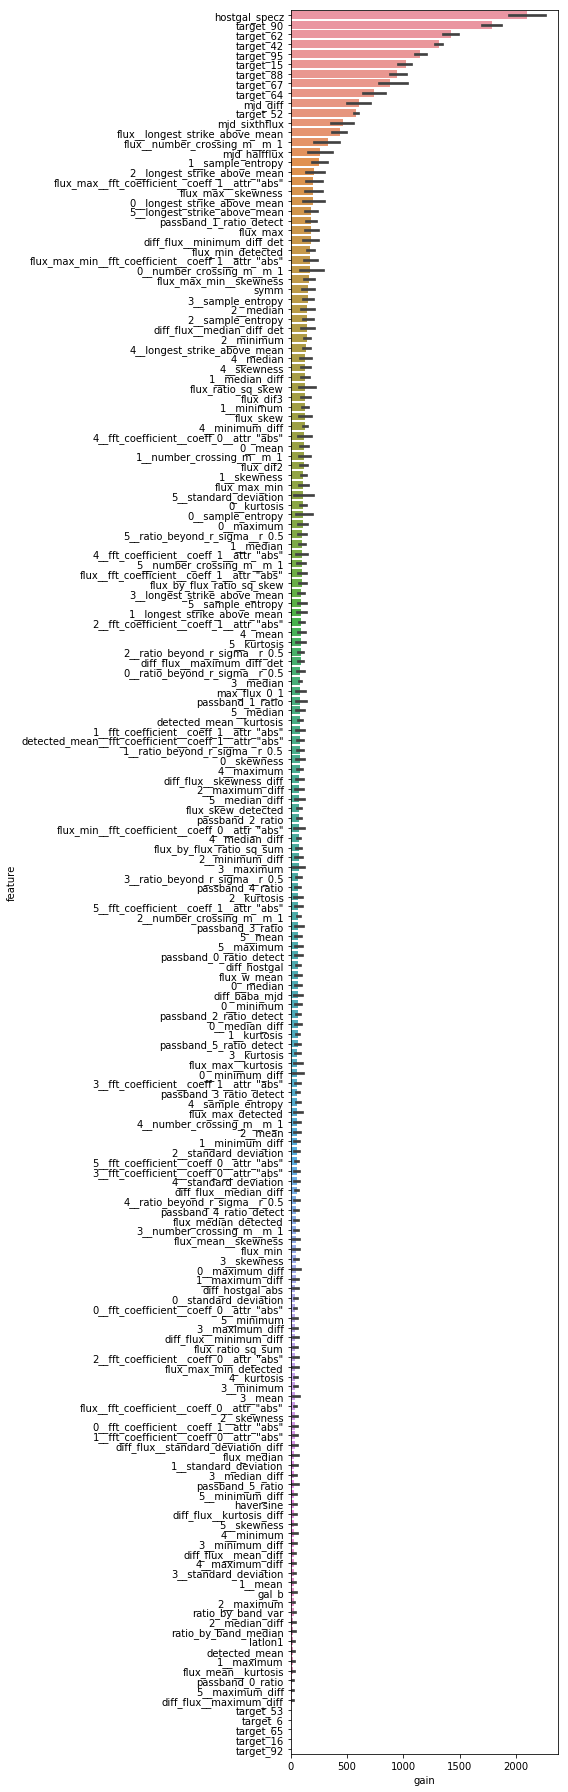

In [355]:
# specz
clfs, importances, oof_preds = train_classifiers_specz(train_specz, y_specz)
save_importances(importances_=importances)

In [356]:
from tqdm import tqdm_notebook

preds_ = None
for clf in tqdm_notebook(clfs):
    if preds_ is None:
        preds_ = clf.predict_proba(test_specz) / len(clfs)
    else:
        preds_ += clf.predict_proba(test_specz) / len(clfs)

In [357]:
test = pd.read_pickle('../input/test_meta_add_feature.pickle')
test = test[test['hostgal_specz'] > 0].reset_index()

In [358]:
preds_99 = np.ones(preds_.shape[0])
for i in range(preds_.shape[1]):
    preds_99 *= (1 - preds_[:, i])

# Create DataFrame from predictions
preds_df_specz = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs[0].classes_])
preds_df_specz['object_id'] = test['object_id']
preds_df_specz['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

In [359]:
preds_df_photoz.tail(3)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
3372494,0.000995,0.064921,0.001010,0.847399,0.007405,0.000992,0.061007,0.000981,0.000993,0.002755,0.001047,0.007001,0.001009,0.002487,130787974,0.071665
3372495,0.001462,0.578493,0.001507,0.251539,0.020898,0.001462,0.031347,0.076071,0.001463,0.007537,0.001528,0.022382,0.001478,0.002831,130788053,0.145628
3372496,0.003697,0.044297,0.003768,0.499524,0.145870,0.003700,0.091145,0.004649,0.003703,0.042143,0.004243,0.144891,0.003747,0.004624,130788054,0.161777


In [360]:
gal_cols = ["class_6","class_16","class_53","class_65","class_92"]
total_cols = ["class_6","class_15","class_16","class_42","class_52","class_53","class_62","class_64","class_65","class_67","class_88","class_90","class_92","class_95","object_id","class_99"]

gal_zero = pd.DataFrame(np.zeros((preds_df_specz.shape[0], len(gal_cols))),columns=gal_cols)
preds_df_specz = pd.merge(preds_df_specz,gal_zero,left_index=True,right_index=True,how='left')
preds_df_specz = preds_df_specz[total_cols]

In [361]:
preds_df_ = preds_df_specz.append(preds_df_photoz)

In [364]:
exgal_cols = ["class_15","class_42","class_52","class_62","class_64","class_67","class_88","class_90","class_95"]
gal_cols = ["class_6","class_16","class_53","class_65","class_92"]
total_cols = ["class_6","class_15","class_16","class_42","class_52","class_53","class_62","class_64","class_65","class_67","class_88","class_90","class_92","class_95"]

In [365]:
# post process
test = pd.read_pickle('../input/test_meta_add_feature.pickle')
pred_hostgal = pd.merge(preds_df_,test[['object_id','hostgal_photoz']],on='object_id',how='left')

pred_gal = pred_hostgal[pred_hostgal['hostgal_photoz']==0].copy()
pred_gal[exgal_cols]=0

pred_ex_gal = pred_hostgal[pred_hostgal['hostgal_photoz']!=0].copy()
pred_ex_gal[gal_cols]=0

pred = pred_gal.append(pred_ex_gal)

In [367]:
del pred['hostgal_photoz']
result = pred.set_index('object_id')

In [368]:
result.to_csv('../output/predictions_1210_v4.csv', float_format='%.6f')